# Cinema of Europe

In [95]:
import pandas as pd
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import LatentDirichletAllocation
import numpy as np
from sklearn.decomposition import NMF
from sklearn.feature_extraction.text import CountVectorizer
from topicwizard.pipeline import make_topic_pipeline
from topicwizard.figures import topic_barcharts
import seaborn as sns
import matplotlib.pyplot as plt
from plots import *

## Get a view of the data

In [5]:
# load data
characters = pd.read_csv('./data/character.metadata.tsv', sep='\t', 
                         names=['wiki_movie_id', 'free_movie_id', 'release', 'char_name', 'actor_birth', 'actor_gender', 'actor_height',
                                 'actor_ethnicity', 'actor_name', 'age_at_release', 'free_map_id', 'free_char_id', 'free_actor_id'] )
movies = pd.read_csv('./data/movie.metadata.tsv', sep='\t', names=['wiki_movie_id', 'free_movie_id', 'movie_name', 'release', 
                                                                   'box_office', 'runtime', 'languages', 'countries', 'genres'])
summaries = df = pd.read_csv('./data/plot_summaries.txt', delimiter='\t', header=None, names=['movie_id', 'plot_summary'], encoding='utf-8')


In [6]:
print(len(characters))
characters.head()

450669


wiki_movie_id free_movie_id     release                   char_name  \
0         975900     /m/03vyhn  2001-08-24                    Akooshay   
1         975900     /m/03vyhn  2001-08-24  Lieutenant Melanie Ballard   
2         975900     /m/03vyhn  2001-08-24         Desolation Williams   
3         975900     /m/03vyhn  2001-08-24          Sgt Jericho Butler   
4         975900     /m/03vyhn  2001-08-24             Bashira Kincaid   

  actor_birth actor_gender  actor_height actor_ethnicity          actor_name  \
0  1958-08-26            F         1.620             NaN      Wanda De Jesus   
1  1974-08-15            F         1.780      /m/044038p  Natasha Henstridge   
2  1969-06-15            M         1.727         /m/0x67            Ice Cube   
3  1967-09-12            M         1.750             NaN       Jason Statham   
4  1977-09-25            F         1.650             NaN         Clea DuVall   

   age_at_release free_map_id free_char_id free_actor_id  
0            42.0  /m/0bgchxw   /m/0bgcj3x    /m/03wcfv7  
1            27.0   /m/0jys3m   /m/0bgchn4     /m/0346l4  
2            32.0   /m/0jys3g   /m/0bgchn_    /m/01vw26l  
3            33.0  /m/02vchl6   /m/0bgchnq     /m/034hyc  
4            23.0  /m/02vbb3r   /m/0bgchp9     /m/01y9xg

In [7]:
print(len(movies))
movies.head()

81741


wiki_movie_id free_movie_id  \
0         975900     /m/03vyhn   
1        3196793     /m/08yl5d   
2       28463795    /m/0crgdbh   
3        9363483    /m/0285_cd   
4         261236     /m/01mrr1   

                                          movie_name     release  box_office  \
0                                     Ghosts of Mars  2001-08-24  14010832.0   
1  Getting Away with Murder: The JonBenét Ramsey ...  2000-02-16         NaN   
2                                        Brun bitter        1988         NaN   
3                                   White Of The Eye        1987         NaN   
4                                  A Woman in Flames        1983         NaN   

   runtime                           languages  \
0     98.0  {"/m/02h40lc": "English Language"}   
1     95.0  {"/m/02h40lc": "English Language"}   
2     83.0  {"/m/05f_3": "Norwegian Language"}   
3    110.0  {"/m/02h40lc": "English Language"}   
4    106.0   {"/m/04306rv": "German Language"}   

                                   countries  \
0  {"/m/09c7w0": "United States of America"}   
1  {"/m/09c7w0": "United States of America"}   
2                     {"/m/05b4w": "Norway"}   
3             {"/m/07ssc": "United Kingdom"}   
4                    {"/m/0345h": "Germany"}   

                                              genres  
0  {"/m/01jfsb": "Thriller", "/m/06n90": "Science...  
1  {"/m/02n4kr": "Mystery", "/m/03bxz7": "Biograp...  
2  {"/m/0lsxr": "Crime Fiction", "/m/07s9rl0": "D...  
3  {"/m/01jfsb": "Thriller", "/m/0glj9q": "Erotic...  
4                            {"/m/07s9rl0": "Drama"}

In [8]:
# Merge datasets on wiki_movie_id
merged_df = pd.merge(characters, movies, on='wiki_movie_id', how='outer', suffixes=('_char', '_mov'))

In [9]:
## Counts the proportions of NaNs per column
nan_proportions = merged_df.isna().mean()

for column, proportion in nan_proportions.items():
    print(f"Column '{column}': {proportion:.2%} NaN values")

Column 'wiki_movie_id': 0.00% NaN values
Column 'free_movie_id_char': 3.72% NaN values
Column 'release_char': 5.85% NaN values
Column 'char_name': 58.81% NaN values
Column 'actor_birth': 26.40% NaN values
Column 'actor_gender': 13.46% NaN values
Column 'actor_height': 66.92% NaN values
Column 'actor_ethnicity': 77.34% NaN values
Column 'actor_name': 3.98% NaN values
Column 'age_at_release': 37.50% NaN values
Column 'free_map_id': 3.72% NaN values
Column 'free_char_id': 58.81% NaN values
Column 'free_actor_id': 3.89% NaN values
Column 'free_movie_id_mov': 0.00% NaN values
Column 'movie_name': 0.00% NaN values
Column 'release_mov': 2.82% NaN values
Column 'box_office': 78.38% NaN values
Column 'runtime': 12.38% NaN values
Column 'languages': 0.00% NaN values
Column 'countries': 0.00% NaN values
Column 'genres': 0.00% NaN values


### Analysis Summary

The dataset looks solid overall. Mostolumns have little missing dataed, except for `actor_ethnicity`, `box_office`, and `release_year`.

`actor_ethnicity` is a major issue since it's key to our analysis. It uses Freebase IDs, which are deprecated, so we'll need to map them to Wikidata IDs during preprocessing.

For missing values, we have two options: eonly ither use the available data or scrape more information from Wikipedia to fill in theaps.



## Preprocessing
#### Uniformize the data

In [12]:
# check consistancy for 'release' and 'free_movie_id' columns in both datasets
## Use the instance from characters if not NaN, otherwise use the instance from movies
merged_df['release'] = merged_df['release_char'].combine_first(merged_df['release_mov'])
merged_df['free_movie_id'] = merged_df['free_movie_id_char'].combine_first(merged_df['free_movie_id_mov'])

In [13]:
# uniformize data in 'release' and 'actor_birth' column to only keep the year and fill the missing values with the median
merged_df['release'] = pd.to_datetime(merged_df['release'], errors='coerce')
merged_df['actor_birth'] = pd.to_datetime(merged_df['actor_birth'], errors='coerce')

merged_df['release_year'] = merged_df['release'].dt.year
merged_df['actor_birth_year'] = merged_df['actor_birth'].dt.year

merged_df.drop(columns=['release', 'release_mov', 'release_char', 'actor_birth'], inplace=True)
merged_df.head(50)

wiki_movie_id free_movie_id_char                   char_name actor_gender  \
0             330          /m/0ktn59                         NaN            F   
1             330          /m/0ktn59                         NaN            F   
2             330          /m/0ktn59                         NaN            F   
3             330          /m/0ktn59                         NaN            F   
4            3217           /m/014hr                S-Mart Clerk            M   
5            3217           /m/014hr                  Fake shemp            M   
6            3217           /m/014hr                Ash Williams            M   
7            3217           /m/014hr                    Evil Ash            M   
8            3217           /m/014hr            Cowardly Warrior            M   
9            3217           /m/014hr                       Linda            F   
10           3217           /m/014hr                      Sheila            F   
11           3217           /m/014hr             Possessed Witch            F   
12           3217           /m/014hr          Duke Henry the Red            M   
13           3217           /m/014hr  Second Supportive Villager            M   
14           3217           /m/014hr                     Wiseman            M   
15           3217           /m/014hr                  Gold Tooth          NaN   
16           3217           /m/014hr                  Blacksmith            M   
17           3217           /m/014hr                 Lord Arthur            M   
18           3333           /m/0151l                         NaN            F   
19           3333           /m/0151l                         NaN            M   
20           3333           /m/0151l                         NaN            F   
21           3333           /m/0151l                         NaN            M   
22           3333           /m/0151l                         NaN            M   
23           3333           /m/0151l                         NaN            F   
24           3333           /m/0151l                         NaN            M   
25           3333           /m/0151l                         NaN            M   
26           3333           /m/0151l                         NaN            M   
27           3333           /m/0151l                         NaN            M   
28           3333           /m/0151l                         NaN            F   
29           3333           /m/0151l                         NaN            F   
30           3333           /m/0151l                         NaN            F   
31           3333           /m/0151l                         NaN            M   
32           3746           /m/017n9              J.F. Sebastian            M   
33           3746           /m/017n9                Rick Deckard            M   
34           3746           /m/017n9                   Roy Batty            M   
35           3746           /m/017n9                     Rachael            F   
36           3746           /m/017n9                        Pris            F   
37           3746           /m/017n9                       Zhora            F   
38           3746           /m/017n9               Leon Kowalski            M   
39           3746           /m/017n9                      Holden            M   
40           3746           /m/017n9                Eldon Tyrell            M   
41           3746           /m/017n9                        Gaff            M   
42           3746           /m/017n9               Hannibal Chew            M   
43           3746           /m/017n9                      Bryant            M   
44           3746           /m/017n9                Taffey Lewis            M   
45           3746           /m/017n9                        Bear            M   
46           3746           /m/017n9                      Kaiser          NaN   
47           3837           /m/018f8               Gabby Johnson            M   
48           3837           /m/018f

#### Data cleaning

In [15]:
# remove useless columns
merged_df.drop(columns=['char_name', 'actor_height', 'runtime'], inplace=True)

In [16]:
import ast

# transform tuples into lists

def extract_list(tuple_str):
    # make a dictionnary
    dict = ast.literal_eval(tuple_str)
    return [value for value in dict.values()]

def tuple_to_list(df, columns):
    """
    Processes a DataFrame by extracting lists from specified columns
    and calculating the maximum number of items in those lists.

    Parameters:
    - df (DataFrame): The DataFrame to be processed.
    - columns (list): List of column names to extract lists from.
    """
    max_counts = {}
    for column in columns:
        column_name = f"{column}_list"
        df[column_name] = df[column].apply(extract_list)

        max_count = df[column_name].apply(len).max()
        max_counts[column] = max_count

    for column, max_value in max_counts.items():
        print(f"Maximum number of {column}: {max_value}")


tuple_columns = ['languages', 'countries', 'genres']
tuple_to_list(merged_df, tuple_columns)
merged_df.head()

Maximum number of languages: 15
Maximum number of countries: 14
Maximum number of genres: 17


wiki_movie_id free_movie_id_char actor_gender actor_ethnicity  \
0            330          /m/0ktn59            F       /m/03ttfc   
1            330          /m/0ktn59            F             NaN   
2            330          /m/0ktn59            F             NaN   
3            330          /m/0ktn59            F             NaN   
4           3217           /m/014hr            M             NaN   

         actor_name  age_at_release free_map_id free_char_id free_actor_id  \
0  Rosa Maria Sardà            54.0  /m/02vbt4w          NaN     /m/0gh6sw   
1        Mercè Pons            29.0  /m/02vb4j6          NaN    /m/0267qhz   
2      Anna Lizaran            51.0  /m/02vc7_7          NaN    /m/0263499   
3      Núria Espert            60.0  /m/02vbd74          NaN    /m/0263yvy   
4         Ted Raimi            26.0  /m/0hgcnkm   /m/0hgcnkq      /m/07qn0   

  free_movie_id_mov  ...  box_office  \
0         /m/0ktn59  ...         NaN   
1         /m/0ktn59  ...         NaN   
2         /m/0ktn59  ...         NaN   
3         /m/0ktn59  ...         NaN   
4          /m/014hr  ...  21502796.0   

                                           languages  \
0  {"/m/01m69": "Catalan language", "/m/06nm1": "...   
1  {"/m/01m69": "Catalan language", "/m/06nm1": "...   
2  {"/m/01m69": "Catalan language", "/m/06nm1": "...   
3  {"/m/01m69": "Catalan language", "/m/06nm1": "...   
4                 {"/m/02h40lc": "English Language"}   

                                   countries  \
0                      {"/m/06mkj": "Spain"}   
1                      {"/m/06mkj": "Spain"}   
2                      {"/m/06mkj": "Spain"}   
3                      {"/m/06mkj": "Spain"}   
4  {"/m/09c7w0": "United States of America"}   

                                              genres free_movie_id  \
0  {"/m/07s9rl0": "Drama", "/m/01t_vv": "Comedy-d...     /m/0ktn59   
1  {"/m/07s9rl0": "Drama", "/m/01t_vv": "Comedy-d...     /m/0ktn59   
2  {"/m/07s9rl0": "Drama", "/m/01t_vv": "Comedy-d...     /m/0ktn59   
3  {"/m/07s9rl0": "Drama", "/m/01t_vv": "Comedy-d...     /m/0ktn59   
4  {"/m/01q03": "Cult", "/m/03npn": "Horror", "/m...      /m/014hr   

  release_year  actor_birth_year                        languages_list  \
0       1996.0            1941.0  [Catalan language, Spanish Language]   
1       1996.0               NaN  [Catalan language, Spanish Language]   
2       1996.0            1944.0  [Catalan language, Spanish Language]   
3       1996.0            1935.0  [Catalan language, Spanish Language]   
4          NaN            1965.0                    [English Language]   

               countries_list  \
0                     [Spain]   
1                     [Spain]   
2                     [Spain]   
3                     [Spain]   
4  [United States of America]   

                                         genres_list  
0                              [Drama, Comedy-drama]  
1                              [Drama, Comedy-drama]  
2                              [Drama, Comedy-drama]  
3                              [Drama, Comedy-drama]  
4  [Cult, Horror, Stop motion, Costume drama, Act...  

[5 rows x 21 columns]

In [17]:
# fill NaNs for actor_gender
gender_distribution = merged_df['actor_gender'].value_counts(normalize=True)
merged_df['actor_gender'] = merged_df['actor_gender'].apply(lambda x: np.random.choice(['F', 'M'], p=gender_distribution) 
                                                        if pd.isna(x) else x)

In [18]:
# fill NaNs with median
merged_df['age_at_release'] = merged_df['age_at_release'].fillna(merged_df['age_at_release'].median())
merged_df['box_office'] = merged_df['box_office'].fillna(merged_df['box_office'].median())
merged_df['release_year'] = merged_df['release_year'].fillna(int(merged_df['release_year'].median()))
merged_df['actor_birth_year'] = merged_df['actor_birth_year'].fillna(int(merged_df['actor_birth_year'].median()))


In [19]:
# fill NaNs with Unknown
merged_df['actor_name'] = merged_df['actor_name'].fillna('Unknown')
merged_df['actor_ethnicity'] = merged_df['actor_ethnicity'].fillna('Unknown')

In [20]:
nan_proportions = merged_df.isna().mean()

for column, proportion in nan_proportions.items():
    print(f"Column '{column}': {proportion:.2%} NaN values")

Column 'wiki_movie_id': 0.00% NaN values
Column 'free_movie_id_char': 3.72% NaN values
Column 'actor_gender': 0.00% NaN values
Column 'actor_ethnicity': 0.00% NaN values
Column 'actor_name': 0.00% NaN values
Column 'age_at_release': 0.00% NaN values
Column 'free_map_id': 3.72% NaN values
Column 'free_char_id': 58.81% NaN values
Column 'free_actor_id': 3.89% NaN values
Column 'free_movie_id_mov': 0.00% NaN values
Column 'movie_name': 0.00% NaN values
Column 'box_office': 0.00% NaN values
Column 'languages': 0.00% NaN values
Column 'countries': 0.00% NaN values
Column 'genres': 0.00% NaN values
Column 'free_movie_id': 0.00% NaN values
Column 'release_year': 0.00% NaN values
Column 'actor_birth_year': 0.00% NaN values
Column 'languages_list': 0.00% NaN values
Column 'countries_list': 0.00% NaN values
Column 'genres_list': 0.00% NaN values


#### Merge ethnicity

In [22]:
import requests

unique_ethnicities = characters['actor_ethnicity'].unique()
freebase_ids = unique_ethnicities


# Function to split the list into batches
def split_into_batches(lst, batch_size):
    for i in range(0, len(lst), batch_size):
        yield lst[i:i + batch_size]

# Create an empty dictionary to store the mappings
freebase_to_wikidata_mapping = {}

# Iterate over batches of Freebase IDs
batch_size = 50  # Set batch size to 50 to avoid long URL issues
for batch in split_into_batches(freebase_ids, batch_size):
    # Create a batch SPARQL query
    query = """
    SELECT ?freebase_id ?item ?itemLabel WHERE {
      VALUES ?freebase_id {""" + " ".join([f'"{fb_id}"' for fb_id in batch]) + """}
      ?item wdt:P646 ?freebase_id.
      SERVICE wikibase:label { bd:serviceParam wikibase:language "[AUTO_LANGUAGE],en". }
    }
    """

    # Endpoint for Wikidata SPARQL
    url = "https://query.wikidata.org/sparql"
    headers = {
        "User-Agent": "Mozilla/5.0",
        "Accept": "application/json"
    }

    # Send the request to Wikidata
    response = requests.get(url, headers=headers, params={"query": query, "format": "json"})

    # Check the status and response
    if response.status_code == 200:
        data = response.json()
        if 'results' in data and 'bindings' in data['results']:
            for result in data['results']['bindings']:
                freebase_id = result['freebase_id']['value']
                wikidata_id = result['item']['value'].split('/')[-1]
                label = result['itemLabel']['value']
                freebase_to_wikidata_mapping[freebase_id] = {
                    "wikidata_id": wikidata_id,
                    "label": label
                }
        else:
            print("No valid data found in response for this batch.")
    else:
        print(f"Error: Received status code {response.status_code} for batch starting with {batch[0]}")

# Print the dictionary to verify the mapping
print("Mappings successfully retrieved:")
for fb_id, details in freebase_to_wikidata_mapping.items():
    print(f"Freebase ID: {fb_id}, Wikidata ID: {details['wikidata_id']}, Label: {details['label']}")



Mappings successfully retrieved:
Freebase ID: /m/02vsw1, Wikidata ID: Q43103, Label: European Americans
Freebase ID: /m/064b9n, Wikidata ID: Q120601, Label: Omaha Tribe of Nebraska
Freebase ID: /m/01qhm_, Wikidata ID: Q141817, Label: German Americans
Freebase ID: /m/0bzkm2, Wikidata ID: Q707133, Label: Taiwanese people
Freebase ID: /m/09kr66, Wikidata ID: Q1140588, Label: Russian Americans
Freebase ID: /m/046cwm, Wikidata ID: Q1255534, Label: Nair
Freebase ID: /m/09vc4s, Wikidata ID: Q1344183, Label: English Americans
Freebase ID: /m/0278pqj, Wikidata ID: Q21999799, Label: British Nigerian
Freebase ID: /m/03ts0c, Wikidata ID: Q121842, Label: French
Freebase ID: /m/0301y_, Wikidata ID: Q190168, Label: Yoruba people
Freebase ID: /m/048z7l, Wikidata ID: Q678551, Label: American Jews
Freebase ID: /m/033tf_, Wikidata ID: Q1075293, Label: Irish Americans
Freebase ID: /m/019kn7, Wikidata ID: Q31340083, Label: Q31340083
Freebase ID: /m/02w7gg, Wikidata ID: Q42406, Label: English people
Freebas

In [23]:
# Assign labels for ethnicity using the batch lookup dictionary
merged_df['actor_ethnicity_label'] = merged_df['actor_ethnicity'].map(
    lambda x: freebase_to_wikidata_mapping.get(x, {}).get('label', 'Unknown')
)

## Form the cinema of Europe cluster

In [25]:
import itertools
from collections import Counter

# combine all lists into one list
all_countries = list(itertools.chain.from_iterable(merged_df['countries_list']))
unique_countries = set(all_countries)
country_counts = Counter(all_countries)

country_counts_df = pd.DataFrame.from_dict(country_counts, orient='index', columns=['count']).reset_index()
country_counts_df.rename(columns={'index': 'country'}, inplace=True)

# Sort by count in descending order
country_counts_df.sort_values(by='count', ascending=False, inplace=True)

print(unique_countries)

{'Iraqi Kurdistan', 'Kingdom of Great Britain', 'Philippines', 'Iran', 'Macau', 'Venezuela', 'Russia', 'Guinea-Bissau', 'Guinea', 'Burma', 'Canada', 'Iraq', 'Portugal', 'United Arab Emirates', 'Senegal', 'Egypt', 'Nepal', 'Ireland', 'Albania', 'Scotland', 'Iceland', 'Germany', 'West Germany', 'Brazil', 'Kenya', 'Australia', 'Crime', 'Isle of Man', 'Lithuania', 'Georgian SSR', 'Cuba', 'Republic of China', 'Austria', 'Singapore', 'Montenegro', 'Argentina', 'Nigeria', 'Weimar Republic', 'Kuwait', 'Cambodia', 'Spain', 'Uzbek SSR', 'India', 'Korea', 'Algeria', 'Northern Ireland', 'Georgia', 'Yugoslavia', 'Kingdom of Italy', 'Greece', 'Armenia', 'Chile', 'Puerto Rico', 'Turkey', 'Burkina Faso', 'Jordan', 'German Democratic Republic', 'France', 'Hungary', 'Peru', 'Panama', 'Japan', 'Ukraine', 'Ukranian SSR', 'Monaco', 'Soviet occupation zone', 'Mali', 'Uzbekistan', 'Netherlands', 'Bahrain', 'Slovakia', 'China', 'Belgium', 'Luxembourg', 'Haiti', 'Switzerland', 'Ethiopia', 'Zambia', 'Congo', 'M

In [26]:
european_countries = ['Slovakia', 'Estonia', 'Bulgaria', 'Scotland', 'England', 'Slovak Republic', 
                      'Luxembourg', 'Netherlands', 'Ukraine', 'Monaco', 'Switzerland', 'Italy',
                      'Kingdom of Great Britain', 'Isle of Man', 'Northern Ireland', 'Ireland',
                      'Sweden', 'Albania', 'France', 'Poland', 'Slovenia', 'Romania', 'Serbia',
                      'Croatia', 'United Kingdom', 'Republic of Macedonia', 'Denmark', 
                      'Czech Republic', 'Austria', 'Spain', 'Russia', 'Bosnia and Herzegovina', 
                      'Czechoslovakia', 'Portugal', 'Iceland', 'Yugoslavia', 'Malta', 'Wales', 
                      'Georgia', 'Cyprus', 'Lithuania', 'Greece', 'Belgium', 'Hungary', 'Germany', 
                      'Norway', 'Finland', 'Montenegro']

# Define a function to check if all countries in the list are European
def is_all_european(countries_list):
    return all(country in european_countries for country in countries_list)

In [53]:
europe_df = merged_df[merged_df['countries_list'].apply(is_all_european)]
print(len(europe_df['wiki_movie_id'].unique()))
print(f"Number of European movies found: {len(europe_df)}")
europe_df.head(60)

24860
Number of European movies found: 104688


wiki_movie_id free_movie_id_char actor_gender actor_ethnicity  \
0              330          /m/0ktn59            F       /m/03ttfc   
1              330          /m/0ktn59            F         Unknown   
2              330          /m/0ktn59            F         Unknown   
3              330          /m/0ktn59            F         Unknown   
243           5729           /m/01qz5            M        /m/0d7wh   
244           5729           /m/01qz5            M       /m/02w7gg   
245           5729           /m/01qz5            M         Unknown   
246           5729           /m/01qz5            M       /m/02w7gg   
247           5729           /m/01qz5            M       /m/02w7gg   
248           5729           /m/01qz5            M         Unknown   
249           5729           /m/01qz5            M         Unknown   
250           5729           /m/01qz5            F         Unknown   
251           5729           /m/01qz5            F         Unknown   
252           5729           /m/01qz5            M         Unknown   
253           5729           /m/01qz5            M         Unknown   
254           5729           /m/01qz5            M         Unknown   
255           5729           /m/01qz5            M         Unknown   
256           5729           /m/01qz5            M       /m/0dj8k3   
257           5729           /m/01qz5            M         Unknown   
258           5729           /m/01qz5            M         Unknown   
259           5729           /m/01qz5            M         Unknown   
260           5729           /m/01qz5            M         Unknown   
261           5729           /m/01qz5            M       /m/02w7gg   
288           8695           /m/02dwj            M         Unknown   
289           8695           /m/02dwj            M         /m/0x67   
290           8695           /m/02dwj            M        /m/041rx   
291           8695           /m/02dwj            M       /m/02ctzb   
292           8695           /m/02dwj            M         Unknown   
293           8695           /m/02dwj            M       /m/033tf_   
294           8695           /m/02dwj            M         Unknown   
295           8695           /m/02dwj            M        /m/041rx   
296           8695           /m/02dwj            M        /m/041rx   
297           8695           /m/02dwj            F         Unknown   
298           8695           /m/02dwj            M         Unknown   
299           8695           /m/02dwj            M        /m/041rx   
300           8695           /m/02dwj            M         Unknown   
301           8695           /m/02dwj            M         Unknown   
302           8695           /m/02dwj            F         Unknown   
303           8695           /m/02dwj            M         Unknown   
304           8695           /m/02dwj            M         Unknown   
305           8695           /m/02dwj            M         Unknown   
358           9429           /m/02k_h            F         Unknown   
359           9429           /m/02k_h            F         Unknown   
360           9429           /m/02k_h            M         Unknown   
361           9429           /m/02k_h            M         Unknown   
362           9429           /m/02k_h            M         Unknown   
363           9429           /m/02k_h            M         Unknown   
364           9429           /m/02k_h            M         Unknown   
365           9429           /m/02k_h            M         Unknown   
366           9429           /m/02k_h            M       /m/02g7sp   
367           9433                NaN            F         Unknown   
445          11167           /m/02_8t            M         Unknown   
446          11167           /m/02_8t            M         Unknown   
447          11167           /m/02_8t            M         Unknown   
448          11167           /m/02_8t            F         Unknown   
449          11167           /m/02_8t            M         Unknown   
450          11

In [28]:
# Save the filtered Bollywood movies metadata for future use
europe_df.to_csv('Data/europe.metadata.tsv', sep='\t', index=False)

## Analysis
### Plottig functions

In [30]:
### Plotting functions

def plot_ethnicity_distribution(df, ethnicity_col, title='Ethnicity Distribution', num_top=10, ylabel='', legend_label='Ethnicity', ax=None, save_path=False):
    """
    Plots the distribution of top ethnicities from a given dataframe.
    
    Parameters:
    - df (DataFrame): The DataFrame containing ethnicity data.
    - ethnicity_col (str): The column name for ethnicity.
    - title (str): Title of the plot.
    - num_top (int): Number of top ethnicities to include in the plot.
    - ylabel (str): Label for the y-axis.
    - legend_label (str): Label for the legend.
    - save_path (str): Path to save the plot as an image (optional).
    
    Returns:
    - None
    """
    # Filter out unknown ethnicities
    filt_ethnicities = df[df[ethnicity_col] != 'Unknown']

    # print the proportion of unknown
    unknown_count = df[df[ethnicity_col] == 'Unknown'].shape[0]
    total_count = df[ethnicity_col].shape[0]
    unknown_proportion = unknown_count / total_count
    print(f'There are {unknown_proportion*100: 1.2f} unkown ethnicities in the dataset')
    
    # Get the top 'num_top' ethnicities
    top_ethnicities = filt_ethnicities[ethnicity_col].value_counts().nlargest(num_top)

    # Plot
    plt.figure(figsize=(10, 6))
    top_ethnicities.plot(kind='pie', autopct='%1.2f%%', startangle=140, cmap='tab20', wedgeprops={'edgecolor': 'black'}, ax=ax)

    if ax:
        ax.set_ylabel(ylabel)
        ax.set_title(title)
    else:
        plt.ylabel(ylabel)
        plt.title(title)

    # Save the plot
    if save_path:
        plt.savefig(save_path, format='png', dpi=300)
        


def plot_age_distribution(df, age_col, gender_col=None, bins=20, palette='viridis', title='Age Distribution', xlabel='Age', ylabel='Frequency', ax=None, save_path=None):
    """
    Plots the age distribution from a given dataframe.
    
    Parameters:
    - df (DataFrame): The DataFrame containing age data.
    - age_col (str): The column name for age.
    - gender_col (str): The column name for gender (optional).
    - bins (int): Number of bins for the histogram.
    - palette (str): Color palette for the plot.
    - title (str): Title of the plot.
    - xlabel (str): Label for the x-axis.
    - ylabel (str): Label for the y-axis.
    - save_path (str): Path to save the plot as an image (optional).
    
    Returns:
    - None
    """
    # Filter the age column based on the age range
    age_filtered = df[(df[age_col] >= 0) & (df[age_col] <= 100)]

    # Create the plot
    if ax is None:
        plt.figure(figsize=(10, 6))
        sns.histplot(data=age_filtered, x=age_col, hue=gender_col, bins=bins, kde=True, palette=palette,hue_order = ['M', 'F'], alpha=0.5, ax=ax)
        plt.xlabel(xlabel)
        plt.ylabel(ylabel)
        plt.title(title)
        plt.tight_layout()
        plt.show()
    else:
        sns.histplot(data=age_filtered, x=age_col, hue=gender_col, bins=bins, hue_order = ['M', 'F'], kde=True, palette=palette, alpha=0.5, ax=ax)
        ax.set_xlabel(xlabel)
        ax.set_ylabel(ylabel)
        ax.set_title(title)  

    # Save the plot if a save path is provided
    if save_path:
        plt.savefig(save_path, format='png', dpi=300)
    


def plot_gender_distribution(df, gender_col, title='Gender Distribution', xlabel='Count', ylabel='Gender', hue_order = ['M', 'F'], palette='viridis', ax=None, save_path=None):
    """
    Plots the gender distribution from a given dataframe.
    
    Parameters:
    - df (DataFrame): The DataFrame containing gender data.
    - gender_col (str): The column name for gender.
    - title (str): Title of the plot.
    - xlabel (str): Label for the x-axis.
    - ylabel (str): Label for the y-axis.
    - palette (str): Color palette for the plot.
    - save_path (str): Path to save the plot as an image (optional).
    
    Returns:
    - None
    """
    # Compute gender counts
    gender_counts = df[gender_col].value_counts()

    # Create the plot
    plt.figure(figsize=(8, 5))
    sns.barplot(y=gender_counts.index, x=gender_counts.values, orient='h', hue=gender_counts.index, palette=palette, edgecolor='black', ax=ax)

    if ax:
        ax.set_xlabel(xlabel)
        ax.set_ylabel(ylabel)
        ax.set_title(title)
    else:
        plt.xlabel(xlabel)
        plt.ylabel(ylabel)
        plt.title(title)
    

    # Save the plot if a save path is provided
    if save_path:
        plt.savefig(save_path, format='png', dpi=300)
    

#### Europe in a whole

First we look at Europe in its whole. But we have to keep in mind that there are very distincts cultures in Europe. We will look at those three types of culture after the analysis of the dataset in its whole.

In [32]:
# get a view on the ethnicities
unique_ethnicities = europe_df['actor_ethnicity_label'].unique()
print(len(unique_ethnicities))
ethnicity_counts = europe_df['actor_ethnicity_label'].value_counts()

316


There are  85.30 unkown ethnicities in the dataset


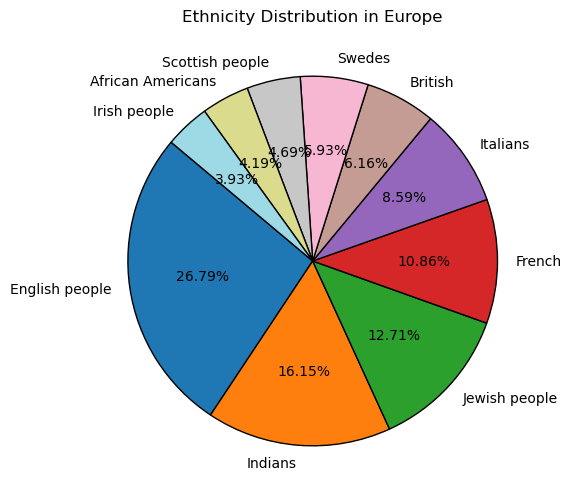

In [33]:
plot_ethnicity_distribution(europe_df, 'actor_ethnicity_label', title='Ethnicity Distribution in Europe', 
                            num_top=10, ylabel='', legend_label='Ethnicity')

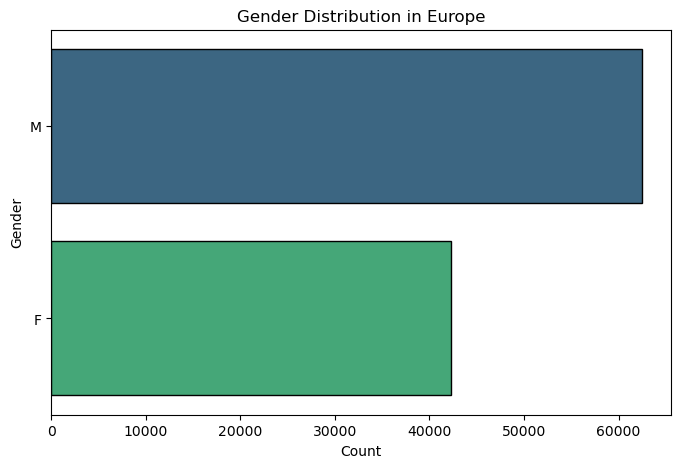

In [34]:
plot_gender_distribution(europe_df, 'actor_gender', title='Gender Distribution in Europe', xlabel='Count', 
                         ylabel='Gender', palette='viridis')

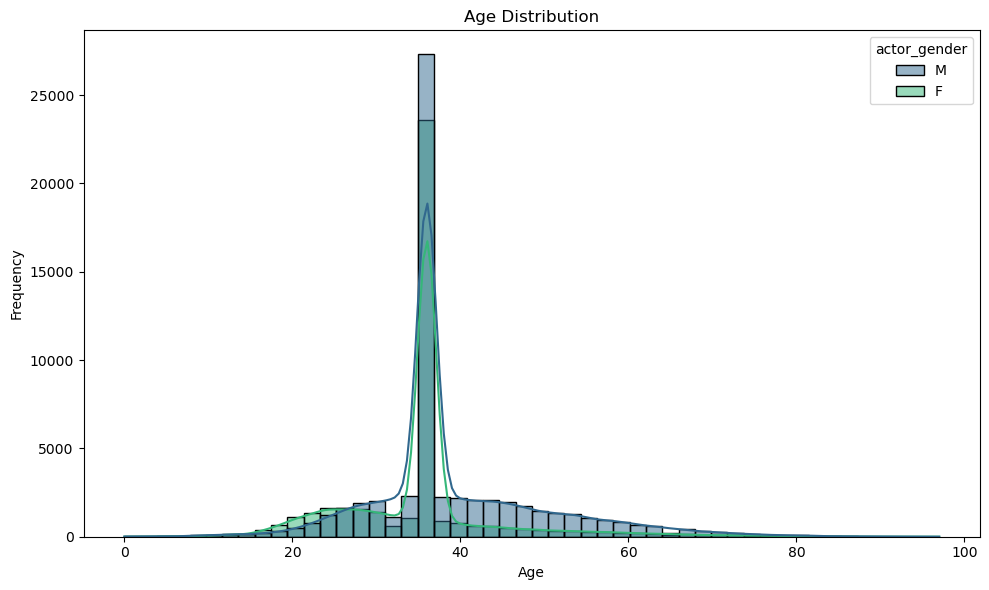

In [55]:
plot_age_distribution(europe_df, 'age_at_release', gender_col='actor_gender', bins=50, 
                      title='Age Distribution', xlabel='Age', ylabel='Frequency')

### European region

Now let's compare the different regions.

In [37]:
east_europe = [
    'Slovakia', 'Slovak Republic', 'Ukraine', 'Estonia', 'Poland', 
    'Bulgaria', 'Romania', 'Serbia', 'Croatia', 'Albania', 
    'Republic of Macedonia', 'Czech Republic', 'Russia', 
    'Bosnia and Herzegovina', 'Czechoslovakia', 'Yugoslavia', 
    'Georgia', 'Lithuania', 'Hungary', 'Montenegro'
]

west_europe = [
    'Scotland', 'England', 'Luxembourg', 'Netherlands', 'Monaco', 
    'Switzerland', 'Italy', 'Kingdom of Great Britain', 'Isle of Man', 
    'Northern Ireland', 'Ireland', 'France', 'Slovenia', 
    'United Kingdom', 'Austria', 'Spain', 'Malta', 'Wales', 
    'Cyprus', 'Greece', 'Belgium', 'Germany', 'Portugal'
]

nordic_europe = [
    'Sweden', 'Denmark', 'Norway', 'Finland', 'Iceland'
]

print(len(european_countries))
print(len(east_europe)+len(west_europe)+len(nordic_europe))

48
48


In [93]:
def is_east_european(countries_list):
    return all(country in east_europe for country in countries_list)
    
def is_west_european(countries_list):
    return all(country in west_europe for country in countries_list)
    
def is_nordic_european(countries_list):
    return all(country in nordic_europe for country in countries_list)
    
east_europe_df = europe_df[europe_df['countries_list'].apply(is_east_european)]
west_europe_df = europe_df[europe_df['countries_list'].apply(is_west_european)]
nordic_europe_df = europe_df[europe_df['countries_list'].apply(is_nordic_european)]

east_europe_df.to_csv('Data/east_europe.metadata.tsv', sep='\t', index=False)
west_europe_df.to_csv('Data/west_europe.metadata.tsv', sep='\t', index=False)
nordic_europe_df.to_csv('Data/nordic_europe.metadata.tsv', sep='\t', index=False)

print(len(east_europe_df))
print(len(west_europe_df))
print(len(nordic_europe_df))

25447
88087
24520


There are  80.60 unkown ethnicities in the dataset
There are  84.22 unkown ethnicities in the dataset
There are  78.51 unkown ethnicities in the dataset


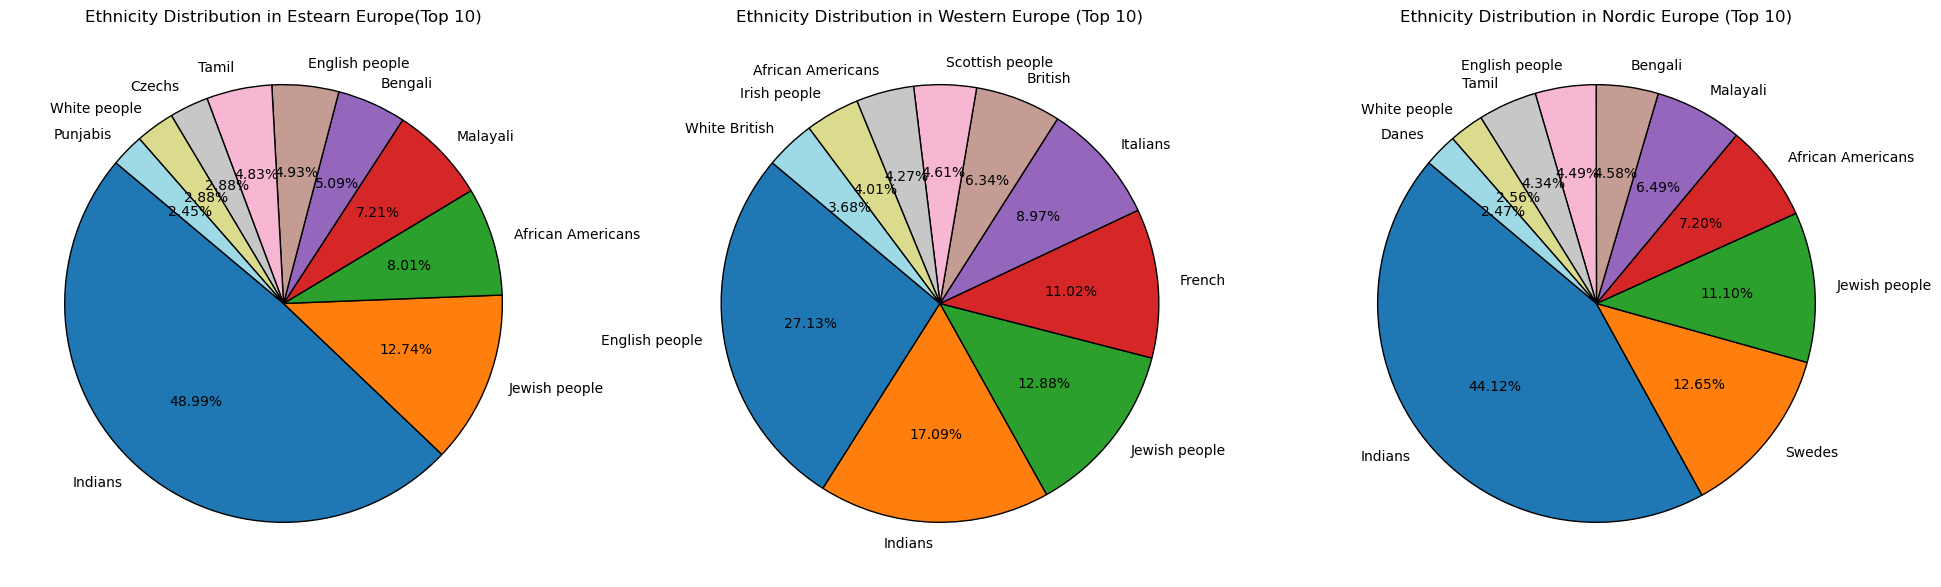

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

In [39]:
fig, axes = plt.subplots(1, 3, figsize=(24, 8))

plot_ethnicity_distribution(east_europe_df, 'actor_ethnicity_label', ax=axes[0], 
                            title='Ethnicity Distribution in Estearn Europe(Top 10)')
plot_ethnicity_distribution(west_europe_df, 'actor_ethnicity_label', ax=axes[1], 
                            title='Ethnicity Distribution in Western Europe (Top 10)')
plot_ethnicity_distribution(nordic_europe_df, 'actor_ethnicity_label', ax=axes[2], 
                            title='Ethnicity Distribution in Nordic Europe (Top 10)')

plt.tight_layout()
plt.show()

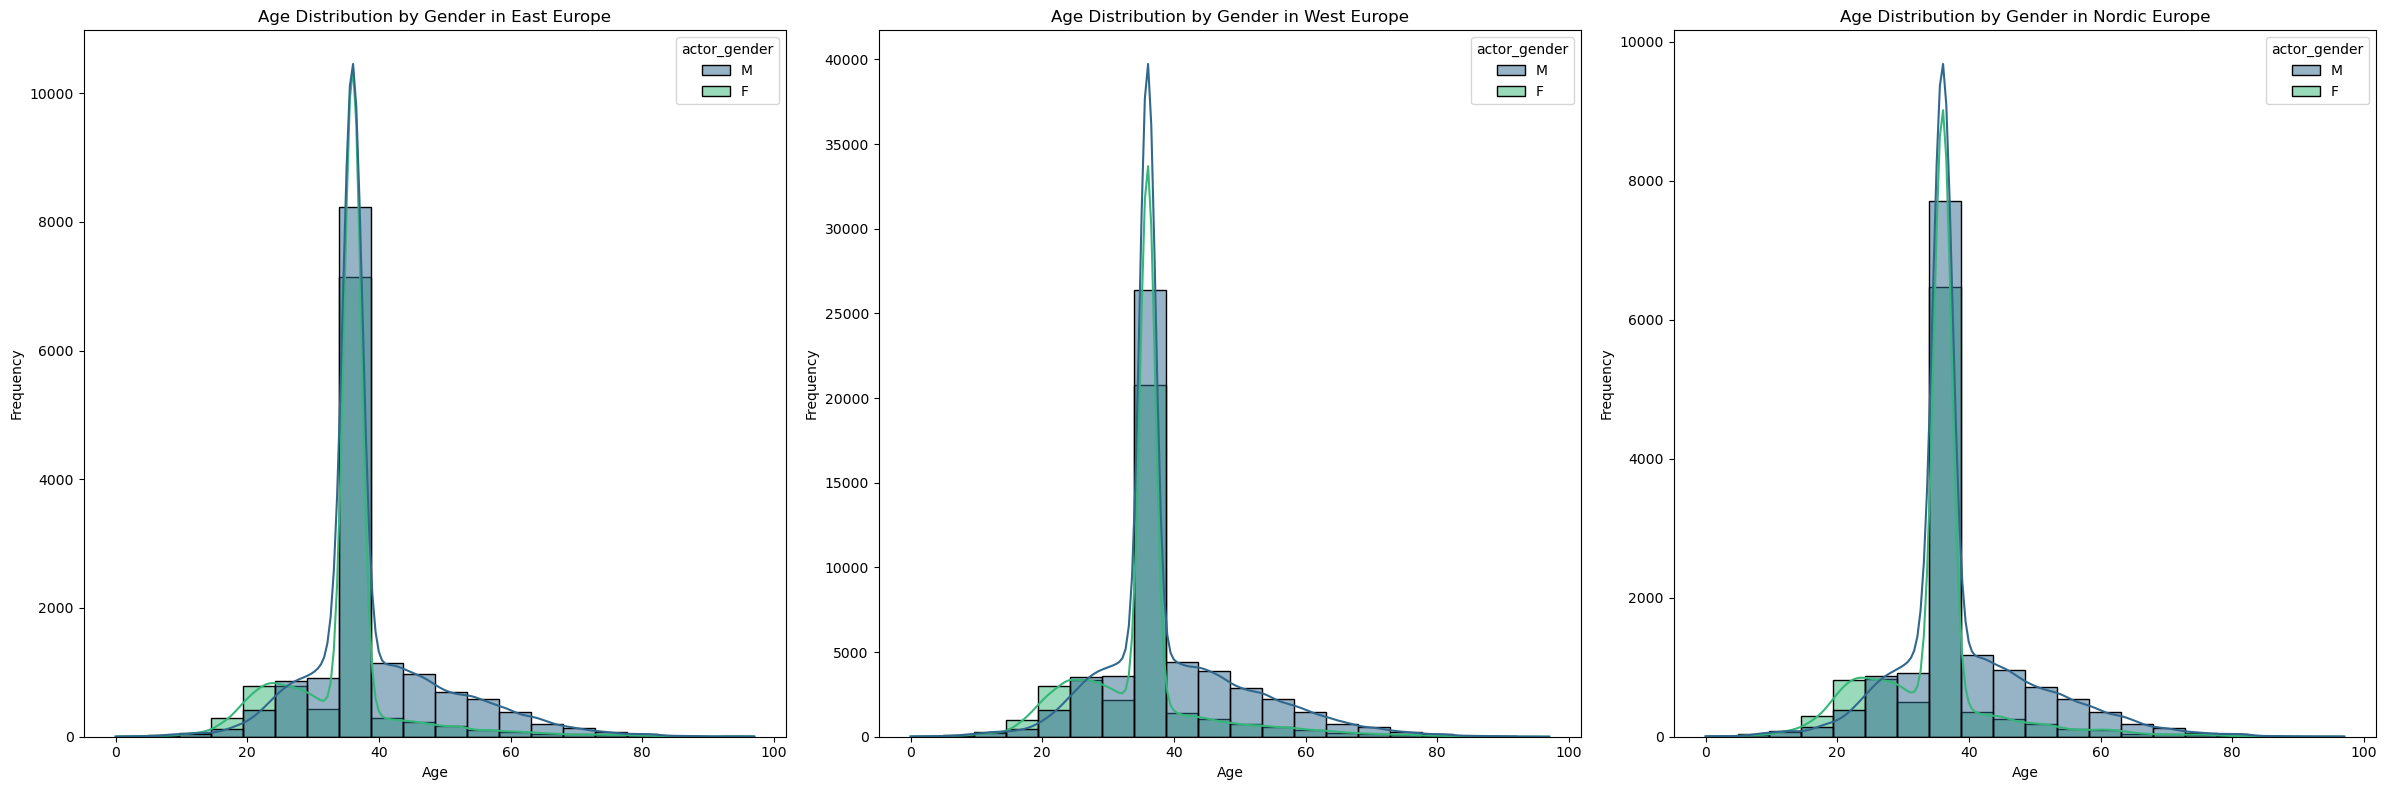

In [40]:
fig, axes = plt.subplots(1, 3, figsize=(24, 8))

plot_age_distribution(east_europe_df, 'age_at_release', 'actor_gender', ax=axes[0], title='Age Distribution by Gender in East Europe')
plot_age_distribution(west_europe_df, 'age_at_release', 'actor_gender', ax=axes[1], title='Age Distribution by Gender in West Europe')
plot_age_distribution(nordic_europe_df, 'age_at_release', 'actor_gender', ax=axes[2], title='Age Distribution by Gender in Nordic Europe')

plt.tight_layout()
plt.show()

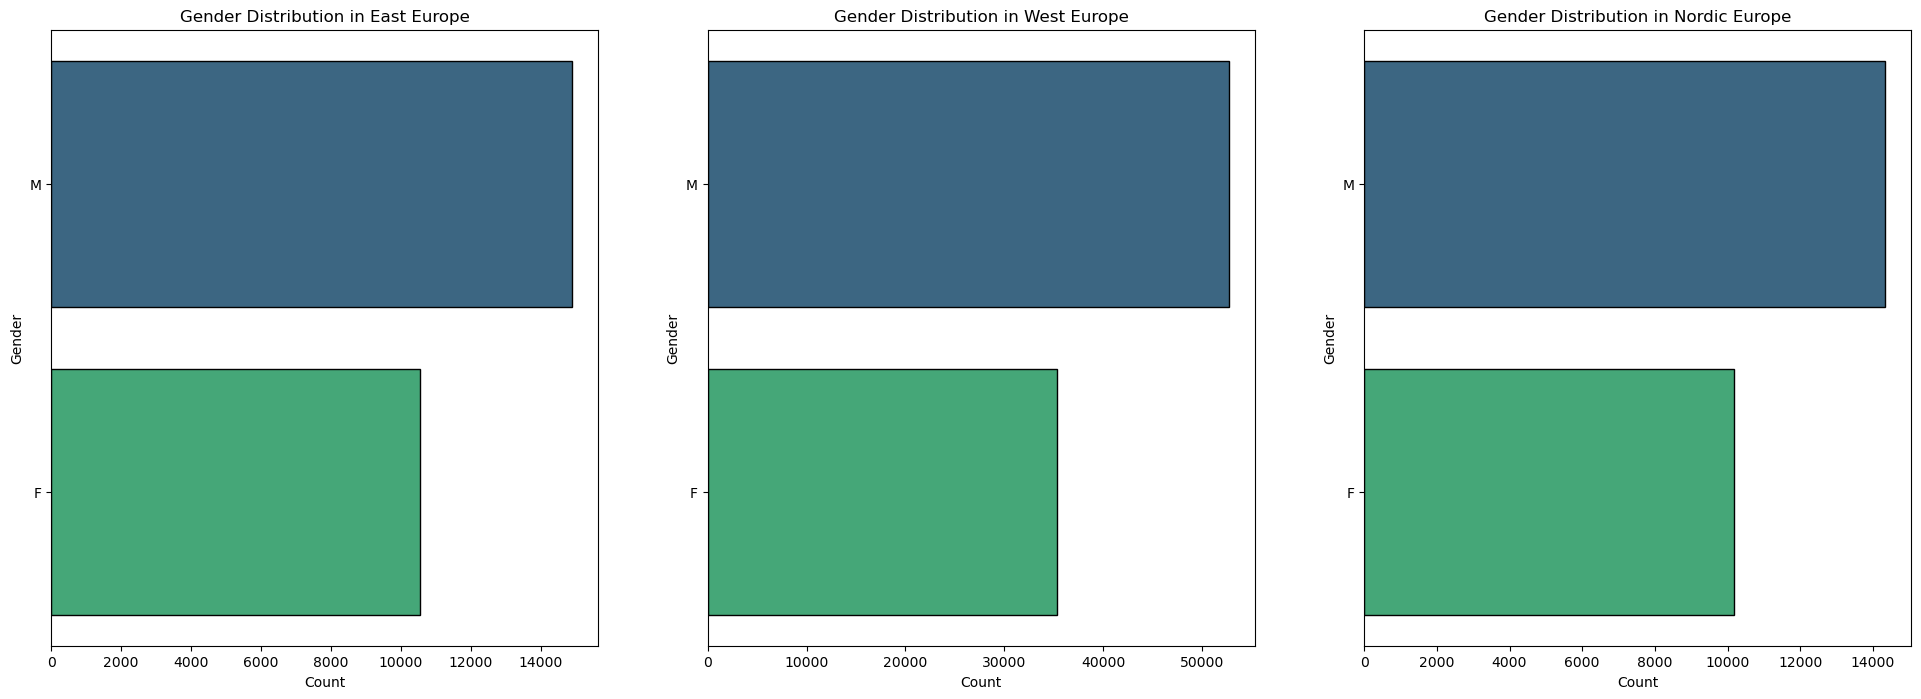

<Figure size 800x500 with 0 Axes>

<Figure size 800x500 with 0 Axes>

<Figure size 800x500 with 0 Axes>

In [41]:
fig, axes = plt.subplots(1, 3, figsize=(24, 8))

plot_gender_distribution(east_europe_df, 'actor_gender', ax=axes[0], title='Gender Distribution in East Europe')
plot_gender_distribution(west_europe_df, 'actor_gender', ax=axes[1], title='Gender Distribution in West Europe')
plot_gender_distribution(nordic_europe_df, 'actor_gender', ax=axes[2], title='Gender Distribution in Nordic Europe')

plt.tight_layout()
plt.show()

### Interactive plots time

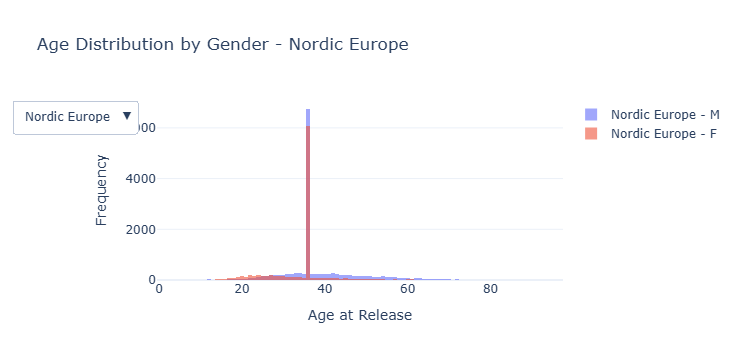

In [49]:
import plotly.graph_objects as go

fig = go.Figure()

# Add histograms for each region by gender
regions = [
    ('Europe', europe_df),
    ('East Europe', east_europe_df),
    ('West Europe', west_europe_df),
    ('Nordic Europe', nordic_europe_df)
]

for region_name, df in regions:
    for gender in ['M', 'F']:
        age_filtered = df[(df['age_at_release'] >= 0) & (df['age_at_release'] <= 100)]
        filtered_df = age_filtered[age_filtered['actor_gender'] == gender]
        fig.add_trace(go.Histogram(
            x=filtered_df['age_at_release'],
            name=f'{region_name} - {gender}',
            opacity=0.6
        ))

fig.update_layout(
    title='Interactive Age Distribution by Gender Across Regions',
    xaxis_title='Age at Release',
    yaxis_title='Frequency',
    barmode='overlay',
    template='plotly_white',
    updatemenus=[
        dict(
            type="dropdown",
            buttons=[
                dict(label="All Regions",
                     method="update",
                     args=[{"visible": [True, True, False, False, False, False, False, False]},
                           {"title": "Age Distribution by Gender - All Regions"}]),
                dict(label="East Europe",
                     method="update",
                     args=[{"visible": [False, False, True, True, False, False, False, False]},
                           {"title": "Age Distribution by Gender - East Europe"}]),
                dict(label="West Europe",
                     method="update",
                     args=[{"visible": [False, False, False, False, True, True, False, False]},
                           {"title": "Age Distribution by Gender - West Europe"}]),
                dict(label="Nordic Europe",
                     method="update",
                     args=[{"visible": [False, False, False, False, False, False, True, True]},
                           {"title": "Age Distribution by Gender - Nordic Europe"}]),
            ],
            direction="down",
            showactive=True
        )
    ]
)

# Show the interactive plot
fig.show()

There are 85.30% unknown ethnicities in the dataset for Europe
There are 80.60% unknown ethnicities in the dataset for East Europe
There are 84.22% unknown ethnicities in the dataset for West Europe
There are 78.51% unknown ethnicities in the dataset for Nordic Europe


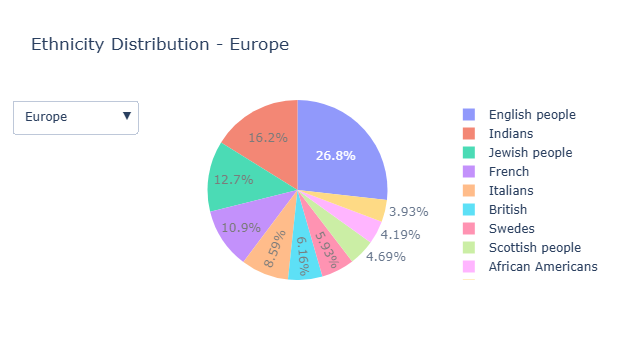

In [73]:
import plotly.graph_objects as go

fig = go.Figure()

# Add ethnicity pie charts for each region
regions = [
    ('Europe', europe_df),
    ('East Europe', east_europe_df),
    ('West Europe', west_europe_df),
    ('Nordic Europe', nordic_europe_df)
]

ethnicity_col = 'actor_ethnicity_label'
num_top = 10

for idx, (region_name, df) in enumerate(regions):
    # Filter out unknown ethnicities
    filt_ethnicities = df[df[ethnicity_col] != 'Unknown']
    
    # Get the top 'num_top' ethnicities
    top_ethnicities = filt_ethnicities[ethnicity_col].value_counts().nlargest(num_top)
    
    # Add a pie trace for each region's top ethnicities
    fig.add_trace(go.Pie(
        labels=top_ethnicities.index,
        values=top_ethnicities.values,
        name=f'{region_name} - Top {num_top} Ethnicities',
        opacity=0.7,
        visible=True if idx == 0 else False  # Only make "Europe" visible initially
    ))

# Update the layout to add interactivity with a dropdown
fig.update_layout(
    title='Interactive Ethnicity Distribution Across Regions',
    template='plotly_white',
    updatemenus=[
        dict(
            type="dropdown",
            buttons=[
                dict(label="Europe",
                     method="update",
                     args=[{"visible": [True, False, False, False]},
                           {"title": "Ethnicity Distribution - Europe"}]),
                dict(label="East Europe",
                     method="update",
                     args=[{"visible": [False, True, False, False]},
                           {"title": "Ethnicity Distribution - East Europe"}]),
                dict(label="West Europe",
                     method="update",
                     args=[{"visible": [False, False, True, False]},
                           {"title": "Ethnicity Distribution - West Europe"}]),
                dict(label="Nordic Europe",
                     method="update",
                     args=[{"visible": [False, False, False, True]},
                           {"title": "Ethnicity Distribution - Nordic Europe"}]),
            ],
            direction="down",
            showactive=True
        )
    ]
)

# Show the interactive plot
fig.show()


In [7]:
#interactive_regions_plot(regions, plot_type='pie', title='Ethinicity Distribution', x_col=None, y_col=None, 
#                         category_col='actor_ethnicity_label', num_top=10, bins = 10)